In [2]:
print("|---------------------------------------------------------------|")
print("|                  This code is developed by                    |")
print("|                      Yogesh Bhattarai                         |")
print("|                (yogeshbhattarai.sb@gmail.com)                 |")
print("|---------------------------------------------------------------|")

|---------------------------------------------------------------|
|                  This code is developed by                    |
|                      Yogesh Bhattarai                         |
|                (yogeshbhattarai.sb@gmail.com)                 |
|---------------------------------------------------------------|


In [4]:
#import following libraries
import glob
import os
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyspatialml import Raster
from glob import glob

In [7]:
import os
import glob 

print("Preparing the necessary raster datasets....................................")
# File and folder paths
main_folder = os.getcwd()

# Define the path to the database folder inside the main folder
dirpath = os.path.join(main_folder, "Rasters")

# Create the stack folder inside the Rasters folder
stack_folder = os.path.join(dirpath, "stack")
os.makedirs(stack_folder, exist_ok=True)

# Define the output raster path
out_fp_raster = os.path.join(stack_folder, "stack.tif")

# Make a search criteria to select the DEM files
search_criteria = "*.tif"
q = os.path.join(dirpath, search_criteria)
criteria_files_raster = glob.glob(q)  # Use glob module here

# Get metadata from the first raster file
with rasterio.open(criteria_files_raster[0]) as src0:
    meta = src0.meta

# Update metadata with the count of raster files
meta.update(count=len(criteria_files_raster))

# Create the stack raster
with rasterio.open(out_fp_raster, 'w', **meta) as dst:
    for id, layer in enumerate(criteria_files_raster, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))


Preparing the necessary raster datasets....................................


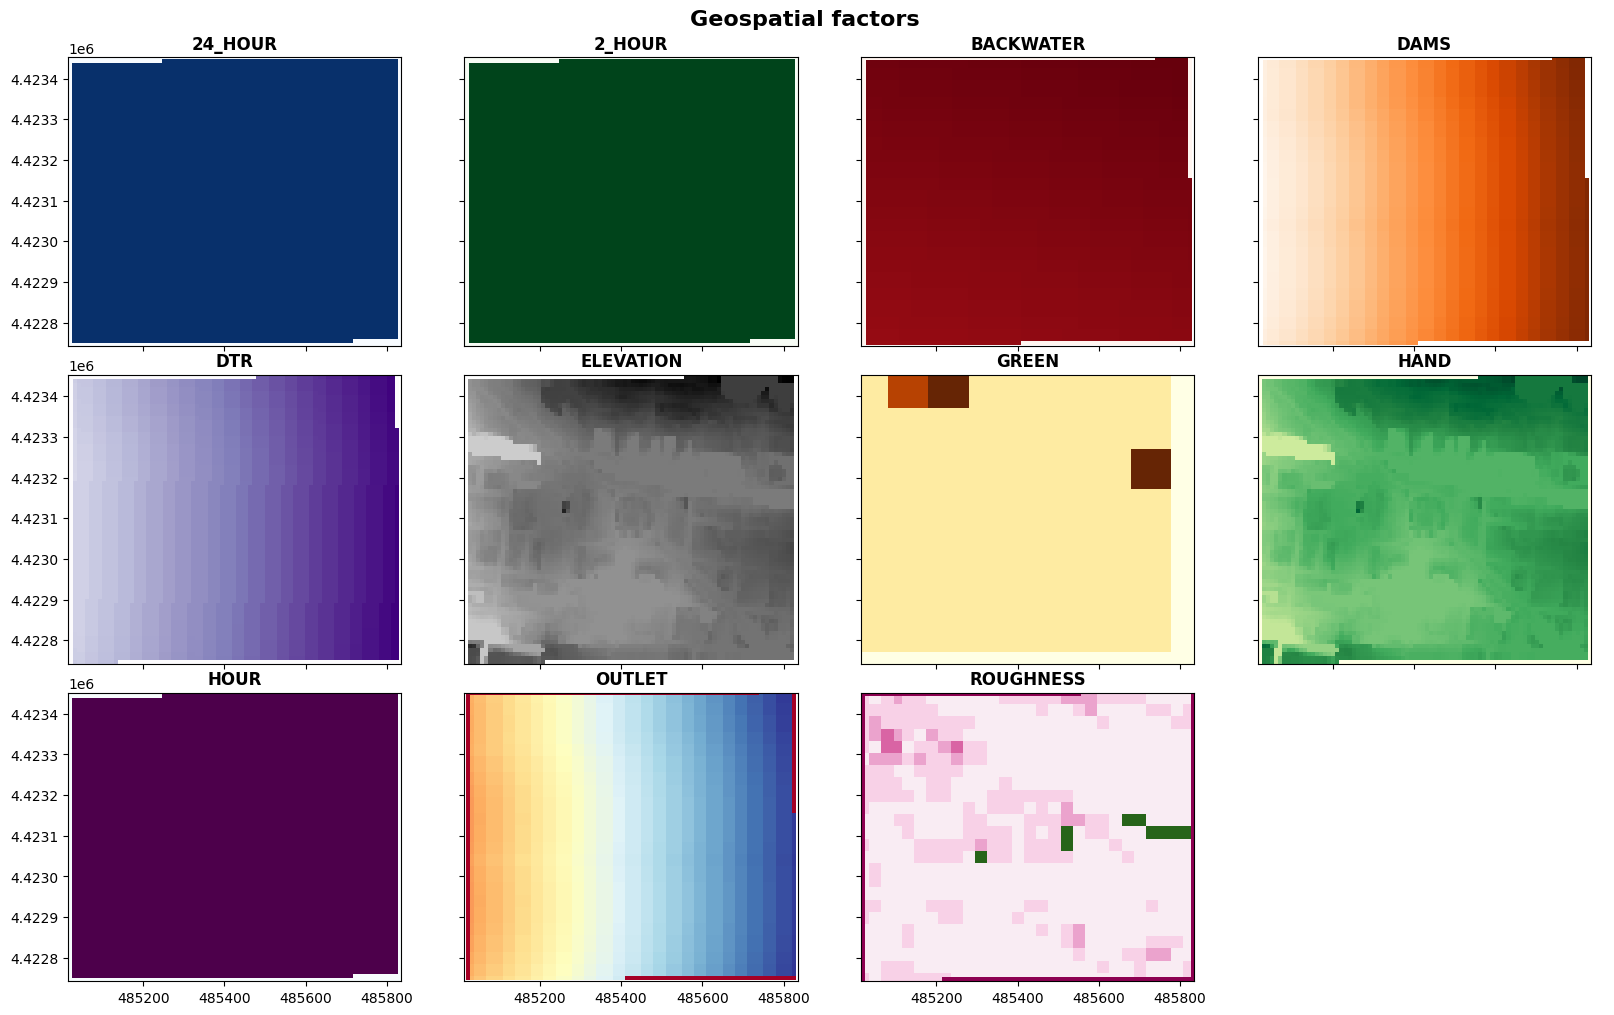

In [13]:
import os
import rasterio
import matplotlib.pyplot as plt

# Select different colormaps to presesnt the raster data
cmaps = ['Blues', 'Greens', 'Reds', 'Oranges', 'Purples', 'Greys', 'YlOrBr', 'YlGn', 'BuPu', 'RdYlBu', 'PiYG']

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(20, 12))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Geospatial factors', fontsize=16, fontweight='bold', y=0.92)

for k in range(0, 3):
    for j in range(0, 4):
        index = k * 4 + j
        if index < len(criteria_files_raster):
            hd = os.path.split(criteria_files_raster[index])
            hdd = os.path.splitext(hd[1])
            ur = hdd[0]
            rst = rasterio.open(criteria_files_raster[index])
            cmap = cmaps[index % len(cmaps)]  # Cycle through colormaps for each subplot
            show(rst, ax=axs[k, j], title=ur.upper(), cmap=cmap)  # Using uppercase for title
        else:
            axs[k, j].axis('off')  # This will turn off axes for empty plots

plt.show()

In [26]:
# Define the path to the Vector folder inside the main folder
vector_folder = os.path.join(main_folder, "Vector")
# Define the path to the flood folder inside the Vector folder
flood_folder = os.path.join(vector_folder, "flood")
# Define the path to the flood shapefile inside the flood folder
flood_shapefile = os.path.join(flood_folder, "flood.shp")
# Read the flood shapefile
flood = gpd.read_file(flood_shapefile)
# Adding columns with default values 0 which will be replaced
flood['elevation'] = 0
flood['dams'] = 0
flood['outlet'] = 0
flood['green'] = 0
flood['roughness'] = 0
flood['hand'] = 0
flood['backwater'] = 0
flood['dtr'] = 0
flood['24_hour'] = 0
flood['2_hour'] = 0
flood['hour'] = 0

In [27]:
rst = rasterio.open(out_fp_raster)
# Create an empty DataFrame to store the flood data
flood_data = pd.DataFrame()
for i in range(11):
    hd = os.path.split(criteria_files_raster[i])
    ur = os.path.splitext(hd[1])[0]
    ele = rst.read(i+1)
    # Calculate flood values for each row using apply() method
    flood[ur] = flood.apply(lambda row: ele[rst.index(row['geometry'].x, row['geometry'].y)], axis=1)

# Define the path for saving the CSV file inside the "Database" folder
output_csv_path = os.path.join("Database", "flood_data.csv")
flood.drop('geometry', axis=1, inplace=True)
# Export the flood data DataFrame to a CSV file
flood.to_csv(output_csv_path, index=False)

In [28]:
# Define the path to the database folder inside the main folder
database_folder_path = os.path.join(main_folder, "Database")
# List all files in the database folder
files_in_database_folder = os.listdir(database_folder_path)
# Iterate through each file in the database folder
for file_name in files_in_database_folder:
    # Check if the file is a CSV file
    if file_name.endswith(".csv"):
        # Construct the full path to the CSV file
        csv_file_path = os.path.join(database_folder_path, file_name)
        print("Loading the database for the training of Random forest model")
        # Read the CSV file into a dataframe
        dataset = pd.read_csv(csv_file_path)

Loading the database for the training of Random forest model


In [29]:
#Dividing the prepared data into the feature data (X) and target data (Y)
print("Please, wait for division of feature data and target data")
X = dataset.iloc[:, 1:18].values
y = dataset.iloc[:, 0].values

Please, wait for division of feature data and target data


In [30]:
# training and testing samples
#selection of test size can vary for different datasets used. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [31]:
#Use the generated estimator
#the parameters used in this modeling have been selected using hyperparameter tuning and running the model for multiple run
RandomForest_model = RandomForestRegressor(max_depth=70, max_features=4, min_samples_leaf=2,
                      n_estimators=100, oob_score=True)
print("Fitting the data for Random Forest Regressor..............")
RandomForest_model.fit(X_train, y_train)
print(RandomForest_model)

Fitting the data for Random Forest Regressor..............
RandomForestRegressor(max_depth=70, max_features=4, min_samples_leaf=2,
                      oob_score=True)


In [32]:
r_preds = Raster(out_fp_raster)

In [33]:
result = r_preds.predict(estimator = RandomForest_model)

In [34]:
results_folder_path = os.path.join(main_folder, "Results")
if not os.path.exists(results_folder_path):
    os.makedirs(results_folder_path)

In [35]:
result.write(os.path.join(results_folder_path, "flood.tif"))

Raster Object Containing 1 Layers
    attribute                                             values
0       names                                       [pred_raw_0]
1       files  [C:/Users/Khwopa/OneDrive - khwopa.edu.np/FLOO...
2        rows                                                 72
3        cols                                                 82
4         res                                       (10.0, 10.0)
5  nodatavals                          [-3.4028234663852886e+38]


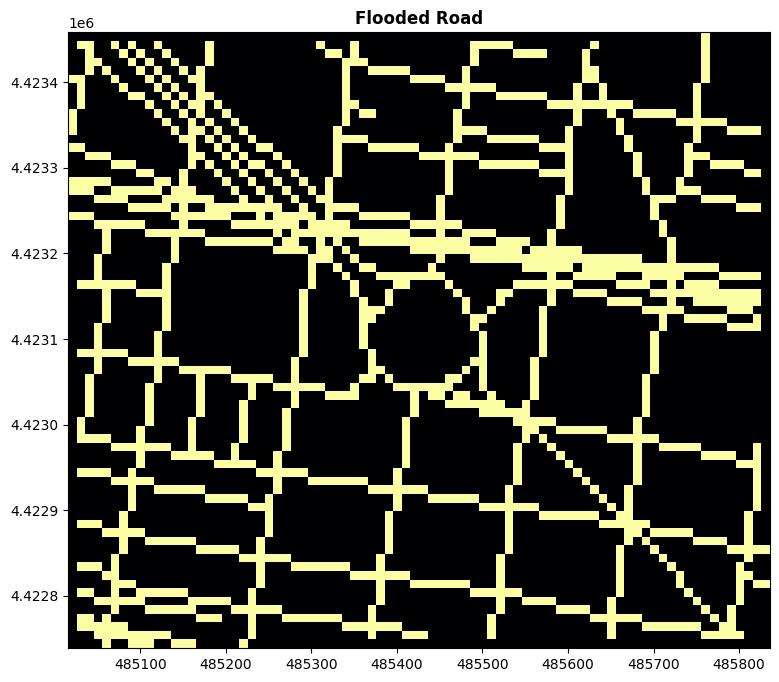

In [51]:
import os
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the Vector folder inside the main folder
vector_folder1 = os.path.join(main_folder, "Vector")
# Define the path to the flood folder inside the Vector folder
vector_folder2 = os.path.join(vector_folder1, "road")
# Define the path to the flood shapefile inside the flood folder
road_shapefile = os.path.join(vector_folder2, "road.shp")

# Read the road shapefile
with fiona.open(road_shapefile, "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

# Open the raster file
with rasterio.open(os.path.join(results_folder_path, "flood.tif")) as src:
    # Mask the raster using the road shapefile
    masked_image, masked_transform = mask(src, features, crop=True)
    # Extract metadata
    meta = src.meta.copy()

# Calculate the min and max values of the masked image
min_val = np.nanmin(masked_image)
max_val = np.nanmax(masked_image)

# Display the masked raster with specified settings
plt.figure(figsize=(10, 8))
# Use the 'inferno' colormap for better visibility of flooded areas
show(masked_image, transform=masked_transform, title='Flooded Road', cmap='inferno', vmin=min_val, vmax=max_val)
plt.show()
